In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive

In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 50

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 196
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 196

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("model_en"))
# model_fr.load_state_dict(torch.load("model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")

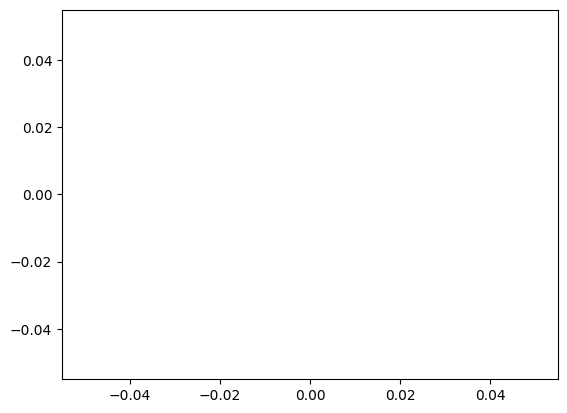

In [4]:
plt.plot(model_fr.loss_list)
plt.plot(model_en.loss_list)

In [ ]:

train_features_reshape= torch.from_numpy(train_features.reshape(train_features.shape[0]//batch_size ,batch_size ,1024, 196)).to(dtype = torch.float32)
#Est ce que cette commande est réellement safe ? Demander !
train_data_fr = [tokenized_fr, train_features_reshape]
train_data_en = [tokenized_en, train_features_reshape]
# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model_fr,model_en,train_data_fr,train_data_en,200,50, True,[1,0])


9.937158584594727
9.173402786254883
2.9514882564544678
5.65503454208374
2.8521502017974854
7.114155292510986
2.3206892013549805
2.830540418624878
2.1921486854553223
2.4780237674713135
4.919887065887451
2.084855318069458
1.8320128917694092
1.896490216255188
1.8222410678863525
1.5847349166870117
1.5835928916931152
1.6811456680297852
1.539656639099121
1.5710735321044922
1.4917492866516113
1.624557614326477
1.3768024444580078
1.3879551887512207
1.288637399673462
1.5589174032211304
1.3900046348571777
1.3051282167434692
1.2622437477111816
1.476199984550476
1.1795616149902344
1.259570837020874
1.3936980962753296
1.1685658693313599
1.2545620203018188
1.1459248065948486
1.199126124382019
1.173963189125061
1.0807256698608398
0.9884935021400452
1.1487767696380615
Iteration : 0 batch numéro : 40 en 832 ms par itération, moyenne loss 1.9035129272937774
0.9585784673690796
1.0642293691635132
0.8654821515083313
0.8394630551338196
1.076385259628296
1.1546993255615234
1.0563398599624634
0.82458543777465

In [ ]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map):
    model_en.eval()
    model_fr.eval()
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
data,target = get_batch(tokenized_en, i)

print("Phrase à traduire : \n" + tensor_to_sentence(target[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr))


#%%

In [ ]:
torch.save(model_fr.state_dict(), "model_fr")
torch.save(model_en.state_dict(), "model_en")
import os
import s3fs
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("model_fr","tordjx/model_fr")
fs.upload("model_en","tordjx/model_fr")

In [ ]:
data ,_= get_batch(tokenized_fr, 0 )
model_fr(data)